# Tile boundaries

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


def display_with_patch_boundaries(img_path: str, patch_size=128) -> None:
    """Display the given image as is and with patch boundaries drawn as red boxes"""
    # Load the image
    img = Image.open(img_path)
    img_array = np.array(img)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Display original image
    ax1.imshow(img_array)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Display image with patch boundaries
    ax2.imshow(img_array)
    ax2.set_title(f'With {patch_size}x{patch_size} Patch Boundaries')
    ax2.axis('off')

    # Get image dimensions
    height, width = img_array.shape[0], img_array.shape[1]

    # Draw patch boundaries
    for x in range(0, width, patch_size):
        for y in range(0, height, patch_size):
            rect = patches.Rectangle(
                (x, y),
                min(patch_size, width - x),
                min(patch_size, height - y),
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax2.add_patch(rect)

    plt.tight_layout()
    plt.show()

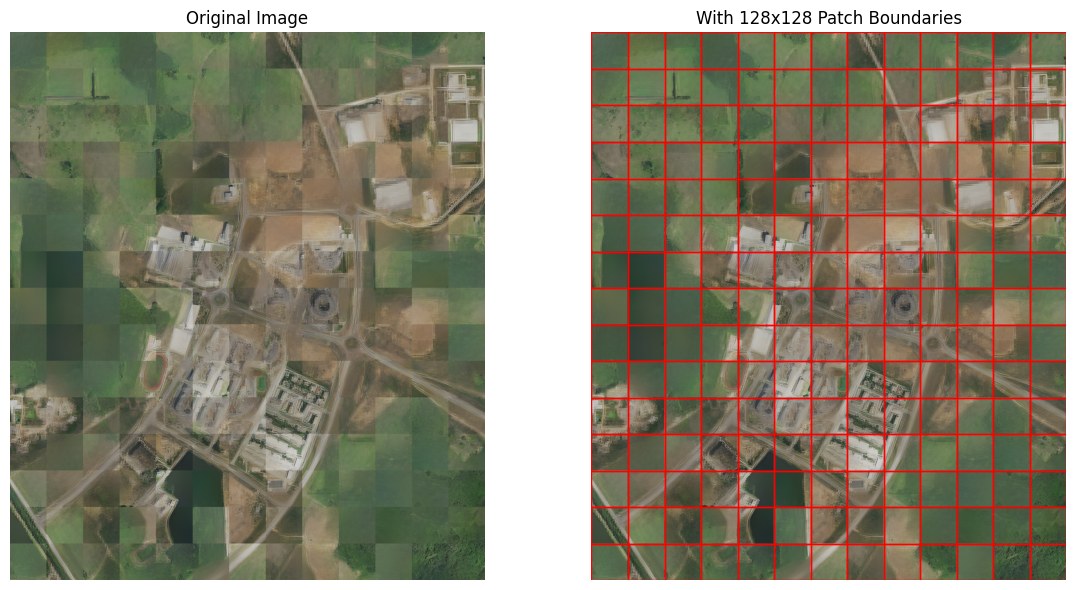

In [3]:
display_with_patch_boundaries("stitched_sr.png")

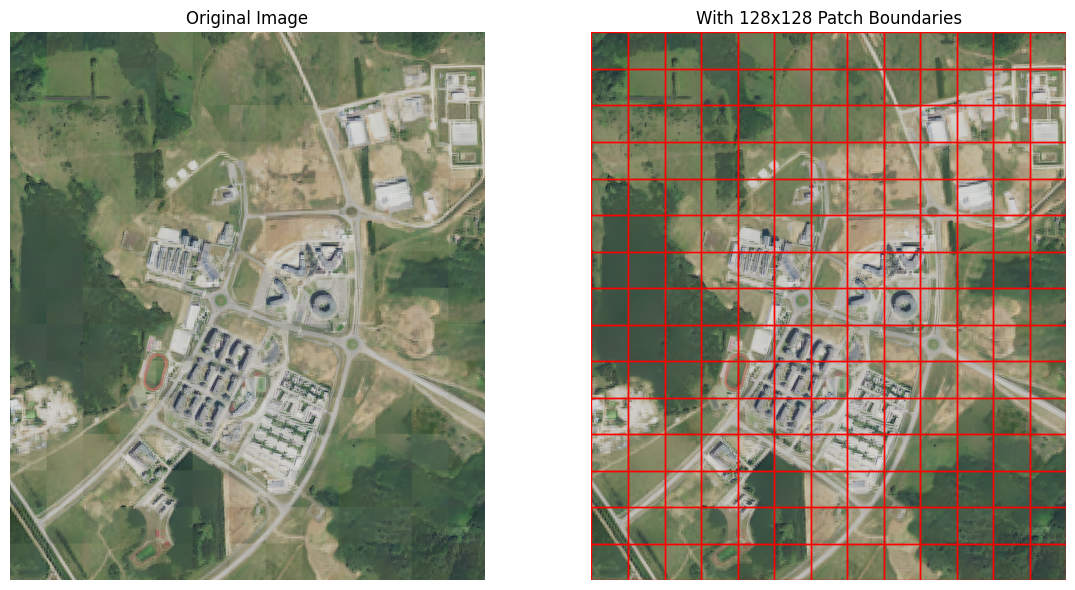

In [4]:
display_with_patch_boundaries("stitched_sr_2.png")

# Version 1

In [18]:
import numpy as np
from collections import Counter
from scipy.stats import entropy


# from skimage.metrics import structural_similarity as ssim

def get_joint_prob_distributions(pixels1, pixels2):
    """Convert two sets of pixels to aligned probability distributions"""
    # Flatten both pixel sets and combine to find all unique colors
    pixels_flat1 = pixels1.reshape(-1, pixels1.shape[-1])
    pixels_flat2 = pixels2.reshape(-1, pixels2.shape[-1])

    # Convert RGB tuples to strings for counting
    all_pixels = [tuple(pixel) for pixel in np.vstack((pixels_flat1, pixels_flat2))]
    unique_colors = list(set(all_pixels))  # Get all unique colors in both regions

    # Create counters for both regions
    counter1 = Counter(tuple(pixel) for pixel in pixels_flat1)
    counter2 = Counter(tuple(pixel) for pixel in pixels_flat2)

    # Create aligned probability distributions
    total1 = max(1, sum(counter1.values()))  # Avoid division by zero
    total2 = max(1, sum(counter2.values()))

    p = np.array([counter1.get(color, 0) / total1 for color in unique_colors])
    q = np.array([counter2.get(color, 0) / total2 for color in unique_colors])

    return p, q


def calculate_cross_entropy(p, q):
    """Calculate cross-entropy between two probability distributions"""
    # To avoid log(0), we add a small epsilon
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1)
    q = np.clip(q, epsilon, 1)

    # Cross-entropy: -sum(p * log(q))
    return -np.sum(p * np.log(q))


def evaluate_tile_transitions(image, tile_size, overlap_size=1, method='cross_entropy'):
    """
    Evaluate transitions between tiles in an image.

    Args:
        image: Input image (H, W, C)
        tile_size: Size of each tile (assumed square)
        overlap_size: Number of rows/columns to consider at edges
        method: 'cross_entropy', 'entropy_diff', 'mse', or 'ssim'

    Returns:
        Average transition score (lower is better for most metrics)
    """
    height, width, channels = image.shape
    scores = []
    total_comparisons = 0

    # Calculate number of tiles in each dimension
    n_tiles_h = height // tile_size
    n_tiles_w = width // tile_size

    # Horizontal transitions (left-right)
    for i in range(n_tiles_h):
        for j in range(n_tiles_w - 1):
            # Current tile (take right edge)
            left_tile = image[i * tile_size:(i + 1) * tile_size,
                        (j + 1) * tile_size - overlap_size:(j + 1) * tile_size]
            # Next tile (take left edge)
            right_tile = image[i * tile_size:(i + 1) * tile_size,
                         (j + 1) * tile_size:(j + 1) * tile_size + overlap_size]

            if method == 'cross_entropy':
                p, q = get_joint_prob_distributions(left_tile, right_tile)
                # Symmetrize the cross-entropy
                score = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
            elif method == 'entropy_diff':
                p, q = get_joint_prob_distributions(left_tile, right_tile)
                score = abs(entropy(p) - entropy(q))
            elif method == 'mse':
                score = np.mean((left_tile - right_tile) ** 2)

            scores.append(score)
            total_comparisons += 1

    # Vertical transitions (top-bottom)
    for i in range(n_tiles_h - 1):
        for j in range(n_tiles_w):
            # Current tile (take bottom edge)
            upper_tile = image[(i + 1) * tile_size - overlap_size:(i + 1) * tile_size,
                         j * tile_size:(j + 1) * tile_size]
            # Next tile (take top edge)
            lower_tile = image[(i + 1) * tile_size:(i + 1) * tile_size + overlap_size,
                         j * tile_size:(j + 1) * tile_size]

            if method == 'cross_entropy':
                p, q = get_joint_prob_distributions(upper_tile, lower_tile)
                score = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
            elif method == 'entropy_diff':
                p, q = get_joint_prob_distributions(upper_tile, lower_tile)
                score = abs(entropy(p) - entropy(q))
            elif method == 'mse':
                score = np.mean((upper_tile - lower_tile) ** 2)

            scores.append(score)
            total_comparisons += 1

    if total_comparisons == 0:
        return 0  # no transitions to evaluate

    return np.mean(scores)


for image_path, tile_size in (("stitched_sr.png", 128), ("stitched_sr_2.png", 128),
                              ("stitched_s2.png", 256), ("TCI_rep_out_1.png", 128),
                              ("TCI_rep_out_re.png", 128)):
    print("Metrics for", image_path)
    image = np.array(Image.open(image_path))

    # tile_size = 128  # Size of each tile
    overlap_size = 4  # Number of rows/columns to compare

    # Evaluate with different methods
    methods = ['cross_entropy', 'entropy_diff', 'mse']
    for method in methods:
        score = evaluate_tile_transitions(image, tile_size, overlap_size, method)
        print(f"{method.upper()} transition score: {score:.4f}")
    print()

Metrics for stitched_sr.png
CROSS_ENTROPY transition score: 22.6145
ENTROPY_DIFF transition score: 0.0960
MSE transition score: 87.1666

Metrics for stitched_sr_2.png
CROSS_ENTROPY transition score: 22.1512
ENTROPY_DIFF transition score: 0.0807
MSE transition score: 74.4404

Metrics for stitched_s2.png
CROSS_ENTROPY transition score: 19.1224
ENTROPY_DIFF transition score: 0.2745
MSE transition score: 33.3436

Metrics for TCI_rep_out_1.png
CROSS_ENTROPY transition score: 19.5746
ENTROPY_DIFF transition score: 0.0342
MSE transition score: 39.8586

Metrics for TCI_rep_out_re.png
CROSS_ENTROPY transition score: 13.0572
ENTROPY_DIFF transition score: 0.0975
MSE transition score: 22.0137



# Version 2

## Core logic (metric calculation & utils)

In [1]:
from pathlib import Path
import numpy as np
from scipy.stats import entropy
from PIL import Image
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap


def get_joint_prob_distributions(pixels1, pixels2):
    """Convert two sets of pixels to aligned probability distributions"""
    pixels_flat1 = pixels1.reshape(-1, pixels1.shape[-1])
    pixels_flat2 = pixels2.reshape(-1, pixels2.shape[-1])

    all_pixels = [tuple(pixel) for pixel in np.vstack((pixels_flat1, pixels_flat2))]
    unique_colors = list(set(all_pixels))

    counter1 = Counter(tuple(pixel) for pixel in pixels_flat1)
    counter2 = Counter(tuple(pixel) for pixel in pixels_flat2)

    total1 = max(1, sum(counter1.values()))
    total2 = max(1, sum(counter2.values()))

    p = np.array([counter1.get(color, 0) / total1 for color in unique_colors])
    q = np.array([counter2.get(color, 0) / total2 for color in unique_colors])

    return p, q


def calculate_cross_entropy(p, q):
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1)
    q = np.clip(q, epsilon, 1)
    return -np.sum(p * np.log(q))

REQUIRES_INNER_VALUES = ['cross_entropy_inner_vs_outer'] # ['mean_inner_vs_outer', 'var_inner_vs_outer']

def evaluate_tile_transitions(image, tile_size, overlap_size=1, method='cross_entropy',
                              return_all_scores=False):
    height, width, channels = image.shape
    scores = []
    n_tiles_h = height // tile_size
    n_tiles_w = width // tile_size
    horizontal_scores = np.zeros((n_tiles_h, n_tiles_w - 1)) if return_all_scores else None
    vertical_scores = np.zeros((n_tiles_h - 1, n_tiles_w)) if return_all_scores else None

    # Horizontal transitions
    for i in range(n_tiles_h):
        for j in range(n_tiles_w - 1):
            # Outer seam from left tile (right overlap) and right tile (left overlap)
            left_outer = image[i * tile_size:(i + 1) * tile_size,
                           (j + 1) * tile_size - overlap_size:(j + 1) * tile_size][:, ::-1]
            right_outer = image[i * tile_size:(i + 1) * tile_size,
                            (j + 1) * tile_size:(j + 1) * tile_size + overlap_size]

            if method in REQUIRES_INNER_VALUES:
                left_inner = image[i * tile_size:(i + 1) * tile_size,
                           (j + 1) * tile_size - 2 * overlap_size:(j + 1) * tile_size - overlap_size][:, ::-1]
                right_inner = image[i * tile_size:(i + 1) * tile_size,
                            (j + 1) * tile_size + overlap_size:(j + 1) * tile_size + 2 * overlap_size]

                if method == 'cross_entropy_inner_vs_outer':
                    # left inner vs right outer
                    p, q = get_joint_prob_distributions(left_inner, right_outer)
                    left_inner_vs_right_outer = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2

                    # right inner vs left outer
                    p, q = get_joint_prob_distributions(right_inner, left_outer)
                    right_inner_vs_left_outer = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
                    score = (left_inner_vs_right_outer + right_inner_vs_left_outer) / 2
            else:
                if method == 'cross_entropy':
                    p, q = get_joint_prob_distributions(left_outer, right_outer)
                    score = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
                elif method == 'mse':
                    score = np.mean((left_outer - right_outer) ** 2)
                # elif method == 'diff_of_mean':
                #     score = abs(left_outer.mean() - right_outer.mean())
                # elif method == 'diff_of_median':
                #     score = abs(np.median(left_outer) - np.median(right_outer))
                else:
                    score = 0

            scores.append(score)
            if return_all_scores:
                horizontal_scores[i, j] = score

    # Vertical transitions
    for i in range(n_tiles_h - 1):
        for j in range(n_tiles_w):
            # Outer seam from upper tile (bottom overlap) and lower tile (top overlap)
            upper_outer = image[(i + 1) * tile_size - overlap_size:(i + 1) * tile_size,
                           j * tile_size:(j + 1) * tile_size][::-1, :]
            lower_outer = image[(i + 1) * tile_size:(i + 1) * tile_size + overlap_size,
                           j * tile_size:(j + 1) * tile_size]

            if method in REQUIRES_INNER_VALUES:
                upper_inner = image[(i + 1) * tile_size - 2 * overlap_size:(i + 1) * tile_size - overlap_size,
                           j * tile_size:(j + 1) * tile_size][::-1, :]
                lower_inner = image[(i + 1) * tile_size + overlap_size:(i + 1) * tile_size + 2 * overlap_size,
                           j * tile_size:(j + 1) * tile_size]

                if method == 'cross_entropy_inner_vs_outer':
                    # upper inner vs lower outer
                    p, q = get_joint_prob_distributions(upper_inner, lower_outer)
                    upper_inner_vs_lower_outer = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2

                    # lower inner vs upper outer
                    p, q = get_joint_prob_distributions(lower_inner, upper_outer)
                    lower_inner_vs_upper_outer = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
                    score = (upper_inner_vs_lower_outer + lower_inner_vs_upper_outer) / 2
            else:
                if method == 'cross_entropy':
                    p, q = get_joint_prob_distributions(upper_outer, lower_outer)
                    score = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
                elif method == 'mse':
                    score = np.mean((upper_outer - lower_outer) ** 2)
                # elif method == 'diff_of_mean':
                #     score = abs(upper_outer.mean() - lower_outer.mean())
                # elif method == 'diff_of_median':
                #     score = abs(np.median(upper_outer) - np.median(lower_outer))
                else:
                    score = 0

            scores.append(score)
            if return_all_scores:
                vertical_scores[i, j] = score

    if return_all_scores:
        return np.mean(scores) if scores else 0, horizontal_scores, vertical_scores
    return np.mean(scores) if scores else 0

## Visualization helpers

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def visualize_hotspots(image_name, image, tile_size, overlap_size, method='cross_entropy',
                       vmin=None, vmax=None, tile_overlap=0, actual_tile_size=None):
    if actual_tile_size is None:
        actual_tile_size = tile_size
    """Visualize transition quality with transparent boundaries"""
    height, width = image.shape[:2]
    n_tiles_h = height // tile_size
    n_tiles_w = width // tile_size



    # Get all boundary scores
    _, h_scores, v_scores = evaluate_tile_transitions(
        image, tile_size, overlap_size, method, return_all_scores=True)

    # Create empty RGBA overlay
    overlay = np.zeros((height, width, 4))  # 4 channels: RGBA

    # Create colormap
    cmap = LinearSegmentedColormap.from_list('hotspot', ['green', 'yellow', 'red'])

    # Calculate global min/max if not provided
    current_vmin = vmin if vmin is not None else min(h_scores.min(), v_scores.min())
    current_vmax = vmax if vmax is not None else max(h_scores.max(), v_scores.max())

    overlap_for_viz = 4

    # Draw horizontal boundaries
    for i in range(n_tiles_h):
        for j in range(n_tiles_w - 1):
            x = (j + 1) * tile_size
            score = h_scores[i, j]
            norm_score = (score - current_vmin) / (current_vmax - current_vmin)
            color = cmap(norm_score)
            overlay[i * tile_size:(i + 1) * tile_size,
            x - overlap_for_viz:x + overlap_for_viz, :] = color

    # Draw vertical boundaries
    for i in range(n_tiles_h - 1):
        for j in range(n_tiles_w):
            y = (i + 1) * tile_size
            score = v_scores[i, j]
            norm_score = (score - current_vmin) / (current_vmax - current_vmin)
            color = cmap(norm_score)
            overlay[y - overlap_for_viz:y + overlap_for_viz,
            j * tile_size:(j + 1) * tile_size, :] = color

    # Set alpha channel (fully opaque for boundaries, transparent elsewhere)
    overlay[..., 3] = np.where(overlay[..., :3].max(axis=-1) > 0, 1, 0.3).astype(float)

    # Create figure with proper layout
    fig = plt.figure(figsize=(16, 8))
    # fig.suptitle(image_name, fontsize=18)

    # Original image (left)
    ax1 = fig.add_axes([0.02, 0.1, 0.45, 0.8])
    ax1.imshow(image)
    ax1.set_title(f"{image_name} | {actual_tile_size=} | {tile_overlap=}", pad=10)
    ax1.axis('off')

    # Overlay image (right)
    ax2 = fig.add_axes([0.47, 0.1, 0.45, 0.8])
    ax2.imshow(image)
    boundary_plot = ax2.imshow(overlay, vmin=current_vmin, vmax=current_vmax, cmap=cmap)

    all_scores = np.concatenate((v_scores, h_scores), axis=None)
    mean_score = all_scores.mean()
    max_score = all_scores.max()
    ax2.set_title(
        f'Transition Hotspots {method.upper()}@{overlap_size}  | mean={mean_score:.2f} | max={max_score:.2f}',
        pad=10)
    ax2.axis('off')

    # Colorbar (right side)
    cax = fig.add_axes([0.94, 0.1, 0.02, 0.8])
    fig.colorbar(boundary_plot, cax=cax, label='Transition Score')

    plt.show()
    return current_vmin, current_vmax


def plot_overlap_dependency(images, tile_size, methods):
    """Plot how scores change with different overlap sizes"""
    overlap_sizes = [1, 2, 4, 8, 16, 24, 32]

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'slategray']

    for method in methods:
        plt.figure(figsize=(12, 6))
        for (img_name, image), color in tqdm(zip(images.items(), colors), total=len(images), desc=f"Plotting {method}"):
            scores = []
            for overlap in overlap_sizes:
                score = evaluate_tile_transitions(image, tile_size, overlap, method)
                scores.append(score)

            plt.plot(overlap_sizes, scores, marker='x', color=color,
                     linestyle='-', label=f'{img_name}')

        plt.xlabel('Metric parameter K (pixels)')
        plt.ylabel('Transition Score')
        plt.title(f'Transition Score vs K for {method.upper()}@K')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## Experiments

In [3]:
target_size = (1664, 1920)
ROOT_DIR = Path("./test_files_for_seaming/models_no_seaming/")
images = {
    "Baseline Single-Image": np.array(Image.open(ROOT_DIR / "no_seaming_small.png")),
    "Baseline Multi-Temporal": np.array(Image.open(ROOT_DIR / "no_seaming_big.png")),
    "Object-Aware": np.array(Image.open(ROOT_DIR / "no_seaming_osm_obj.png")),
    "Location Embeddings": np.array(Image.open(ROOT_DIR / "no_seaming_loc_emb.png")),
    "Compression-Guided": np.array(Image.open(ROOT_DIR / "no_seaming_bpp.png")),
    "EDiffSR": np.array(Image.open(ROOT_DIR / "no_seaming_ediffsr.png")),
}

In [6]:
tile_size = 128
methods = ['mse']
overlap_size = 4 #2

In [7]:
# First pass: Calculate global min/max for each method
global_ranges = {}
for method in methods:
    all_scores = []
    for name, image in images.items():
        total, h_scores, v_scores = evaluate_tile_transitions(image, tile_size, overlap_size, method, return_all_scores=True)
        print(method, name, total)
        all_scores.extend(h_scores.flatten())
        all_scores.extend(v_scores.flatten())
    global_ranges[method] = (np.min(all_scores), np.max(all_scores))

# Second pass: Visualize with consistent ranges
# for method in methods:
#     vmin, vmax = global_ranges[method]
#     print(f"\nMethod: {method} | Global range: [{vmin:.2f}, {vmax:.2f}]")
#
#     for img_name, image in images.items():
#         _ = visualize_hotspots(img_name, image, tile_size, overlap_size,
#                                method=method, vmin=vmin, vmax=vmax)

mse Baseline Single-Image 87.21478440089778
mse Baseline Multi-Temporal 74.69023725253223
mse Object-Aware 61.28560766286833
mse Location Embeddings 35.20856893128453
mse Compression-Guided 64.22583232619705
mse EDiffSR 27.026906724792816


Plotting mse: 100%|██████████| 6/6 [00:00<00:00, 15.28it/s]


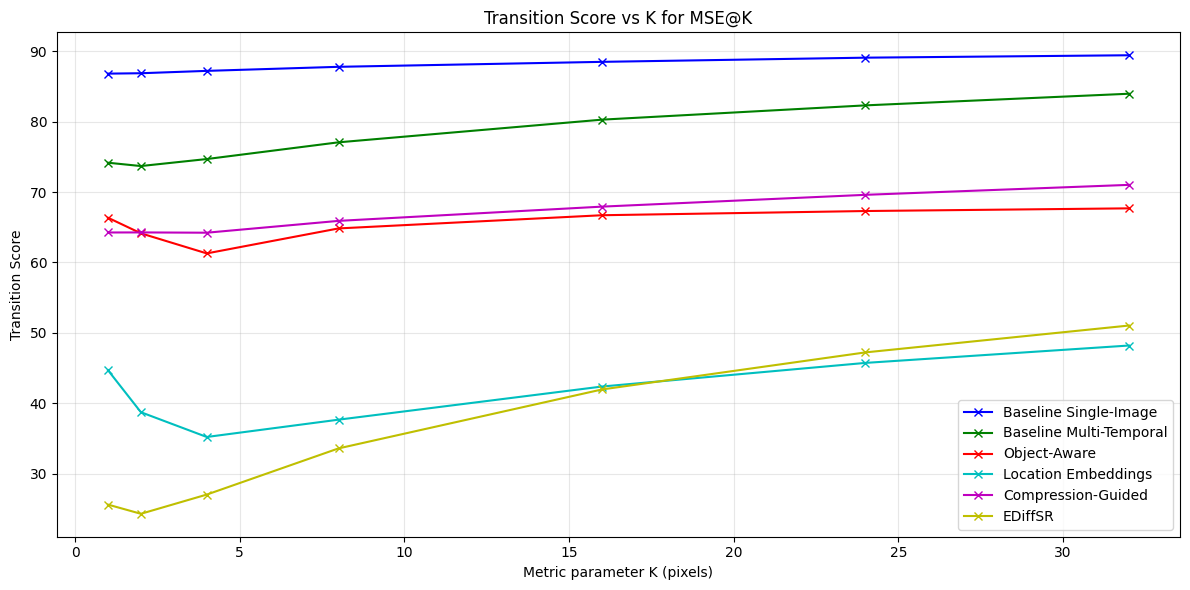

Plotting cross_entropy: 100%|██████████| 6/6 [02:06<00:00, 21.11s/it]


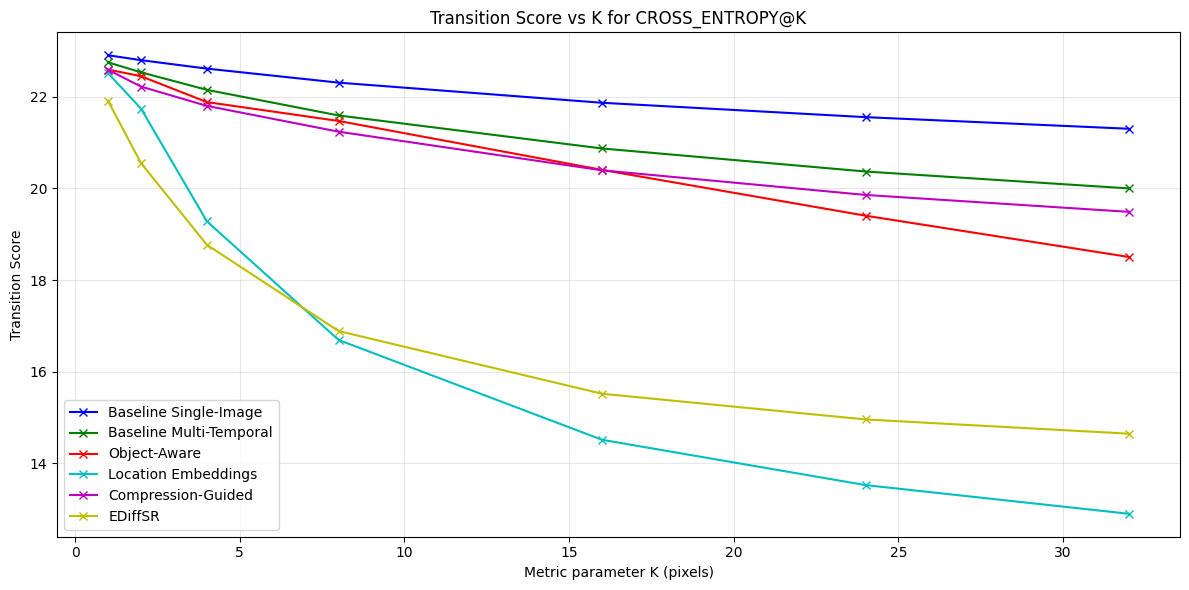

Plotting cross_entropy_inner_vs_outer: 100%|██████████| 6/6 [04:12<00:00, 42.12s/it]


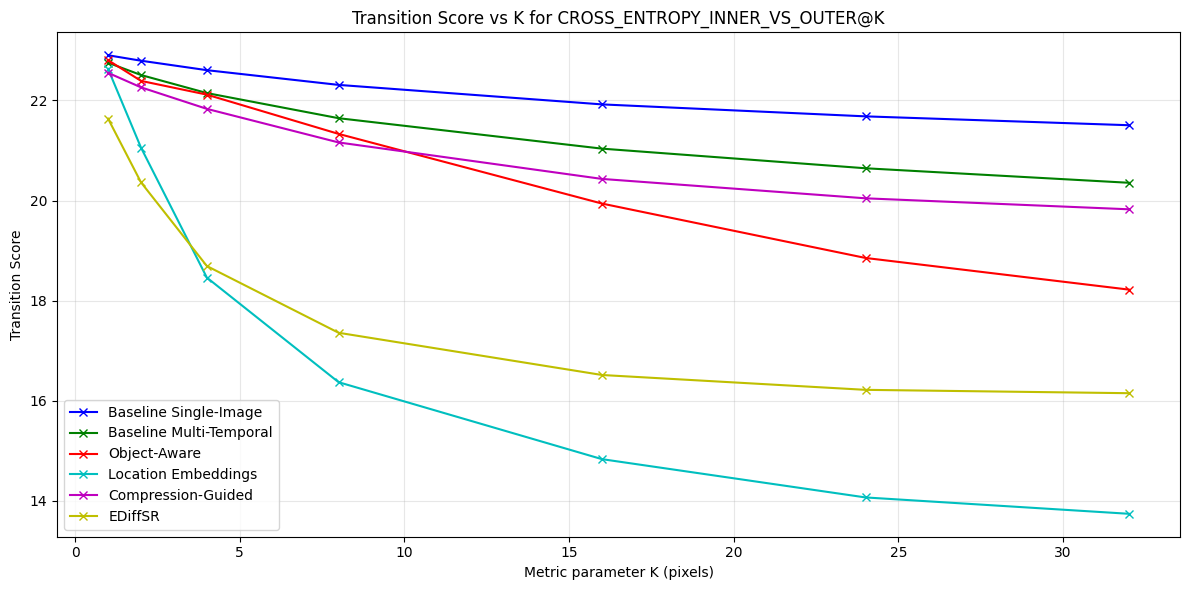

In [44]:
plot_overlap_dependency(images, tile_size, methods)

In [46]:
ROOT_DIR = Path("./test_files_for_seaming/comparing_smoothing/")
images = {
    "Mean (same weights)": np.array(Image.open(ROOT_DIR / "mean.png")),
    "Linear Weights": np.array(Image.open(ROOT_DIR / "weighted.png")),
    "Sine Weights": np.array(Image.open(ROOT_DIR / "sine.png")),
    "Hann Weights": np.array(Image.open(ROOT_DIR / "hann.png")),
}

In [ ]:
# First pass: Calculate global min/max for each method
global_ranges = {}
for method in methods:
    all_scores = []
    for name, image in images.items():
        _, h_scores, v_scores = evaluate_tile_transitions(image, tile_size, overlap_size, method, return_all_scores=True)
        all_scores.extend(h_scores.flatten())
        all_scores.extend(v_scores.flatten())
    global_ranges[method] = (np.min(all_scores), np.max(all_scores))

# Second pass: Visualize with consistent ranges
for method in methods:
    vmin, vmax = global_ranges[method]
    print(f"\nMethod: {method} | Global range: [{vmin:.2f}, {vmax:.2f}]")

    for img_name, image in images.items():
        _ = visualize_hotspots(img_name, image, tile_size, overlap_size,
                               method=method, vmin=vmin, vmax=vmax)

Plotting mse: 100%|██████████| 4/4 [00:00<00:00, 13.83it/s]


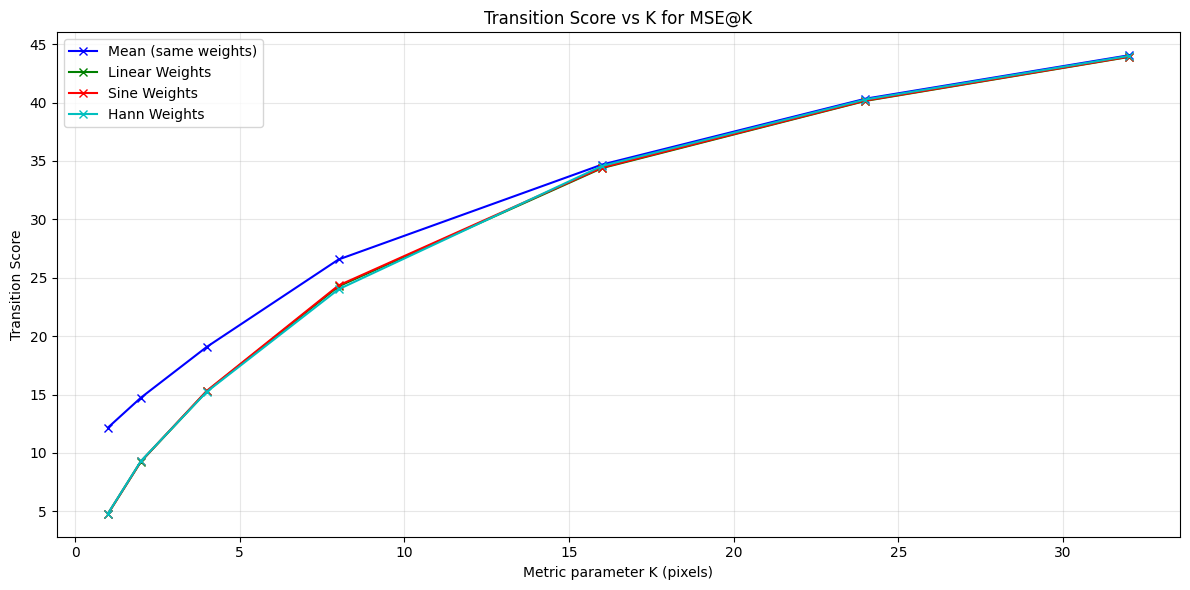

Plotting cross_entropy: 100%|██████████| 4/4 [01:20<00:00, 20.02s/it]


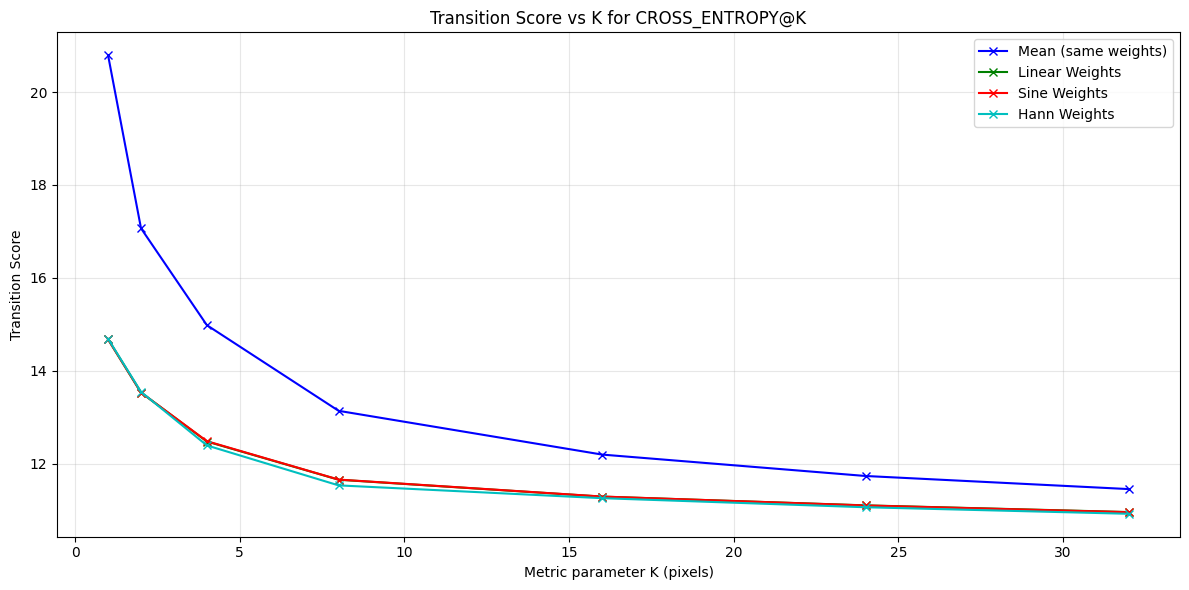

Plotting cross_entropy_inner_vs_outer: 100%|██████████| 4/4 [02:41<00:00, 40.38s/it]


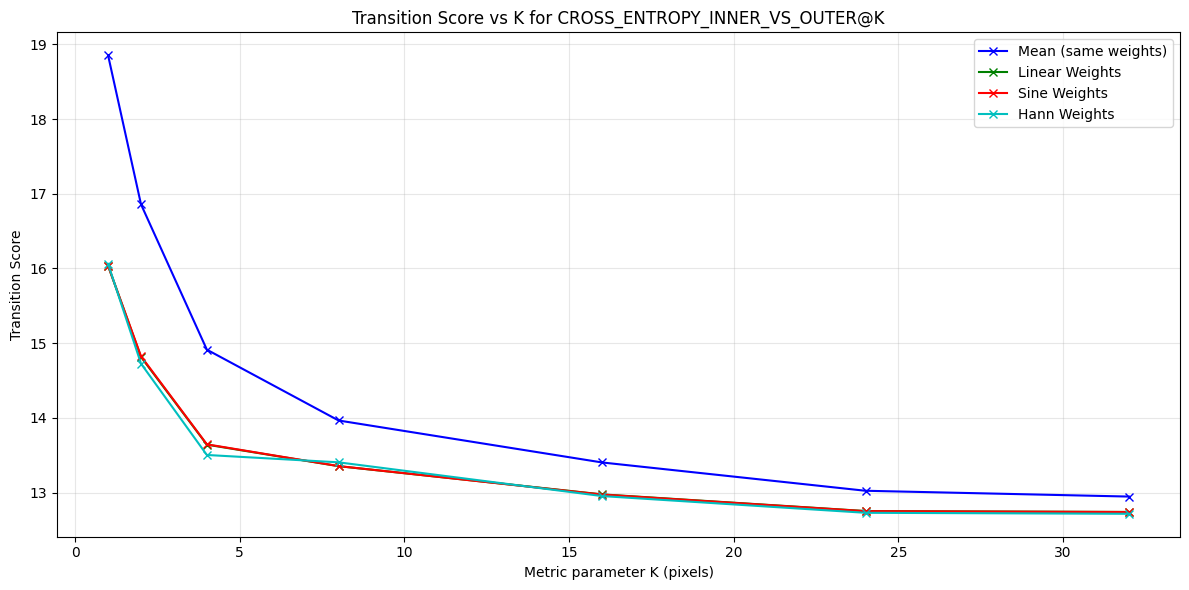

In [48]:
plot_overlap_dependency(images, tile_size, methods)

In [ ]:
ROOT_DIR = Path("./test_files_for_seaming/comparing_overlap/")
images = {
    "0 pixel overlap": np.array(Image.open(ROOT_DIR / "0.png")),
    "4 (16) pixel overlap": np.array(Image.open(ROOT_DIR / "hann_4.png")),
    "8 (32) pixel overlap": np.array(Image.open(ROOT_DIR / "hann_8.png")),
    "16 (64) pixel overlap": np.array(Image.open(ROOT_DIR / "hann_16.png")),
}
# First pass: Calculate global min/max for each method
global_ranges = {}
for method in methods:
    all_scores = []
    for name, image in images.items():
        _, h_scores, v_scores = evaluate_tile_transitions(image, tile_size, overlap_size, method,
                                                          return_all_scores=True)
        all_scores.extend(h_scores.flatten())
        all_scores.extend(v_scores.flatten())
    global_ranges[method] = (np.min(all_scores), np.max(all_scores))

# Second pass: Visualize with consistent ranges
for method in methods:
    vmin, vmax = global_ranges[method]
    print(f"\nMethod: {method} | Global range: [{vmin:.2f}, {vmax:.2f}]")

    for img_name, image in images.items():
        _ = visualize_hotspots(img_name, image, tile_size, overlap_size,
                               method=method, vmin=vmin, vmax=vmax)

Plotting mse: 100%|██████████| 4/4 [00:00<00:00, 15.41it/s]


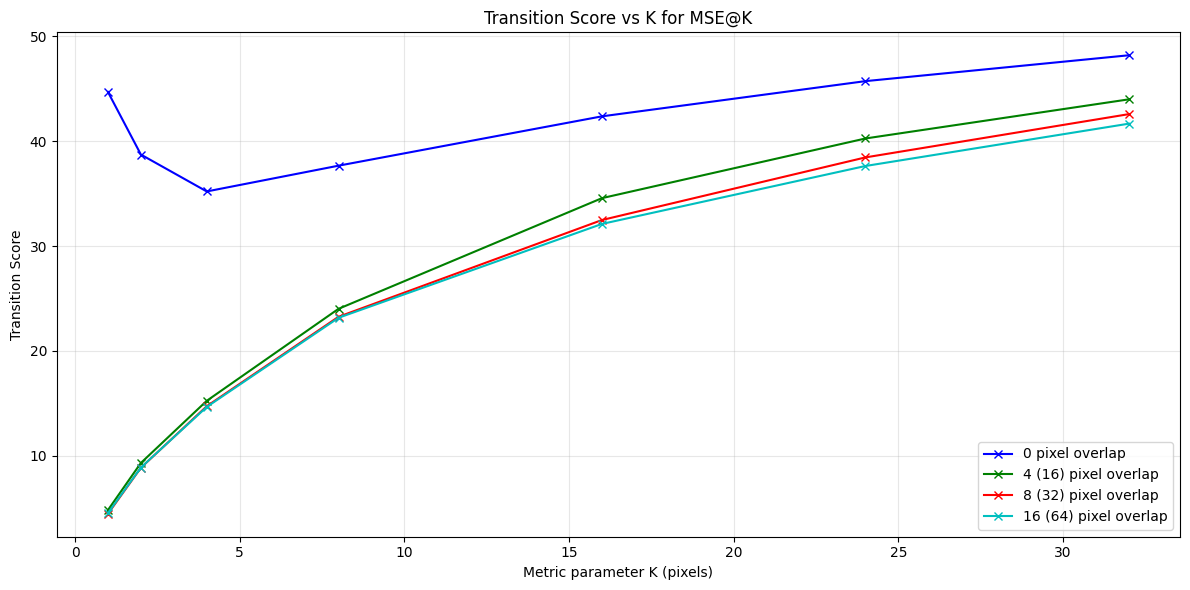

Plotting cross_entropy: 100%|██████████| 4/4 [01:20<00:00, 20.06s/it]


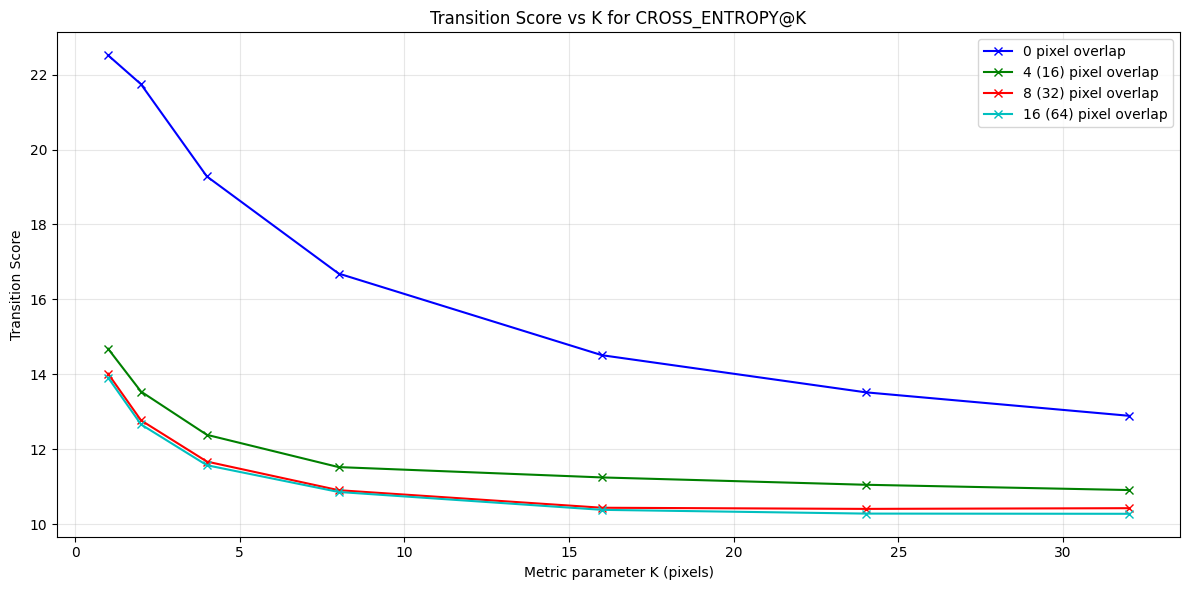

Plotting cross_entropy_inner_vs_outer: 100%|██████████| 4/4 [02:41<00:00, 40.42s/it]


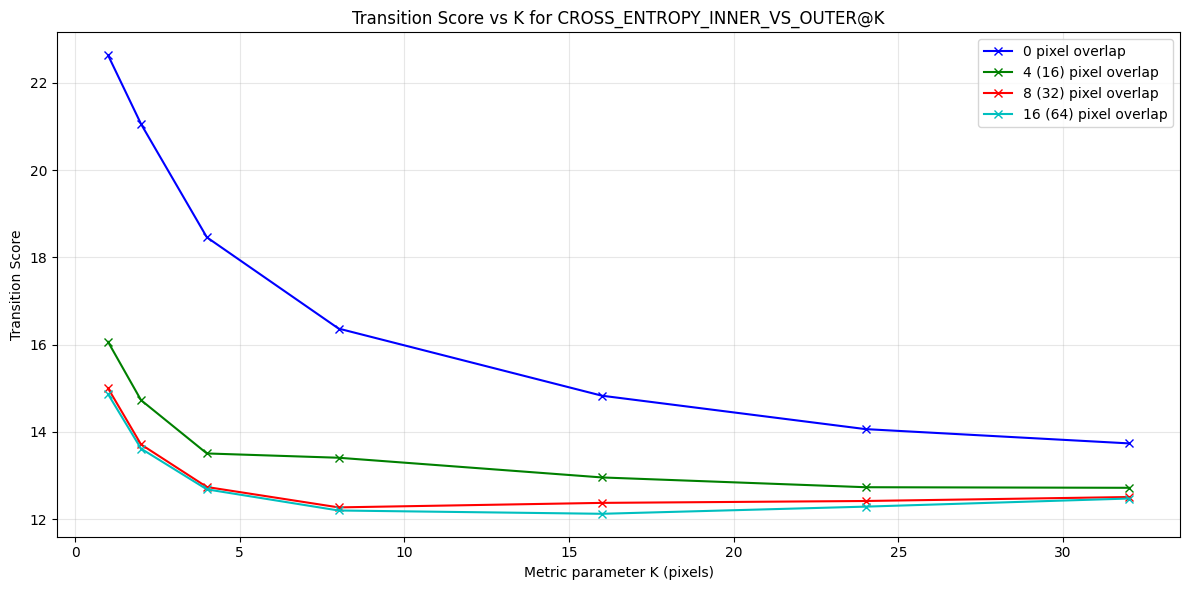

In [53]:
plot_overlap_dependency(images, tile_size, methods)

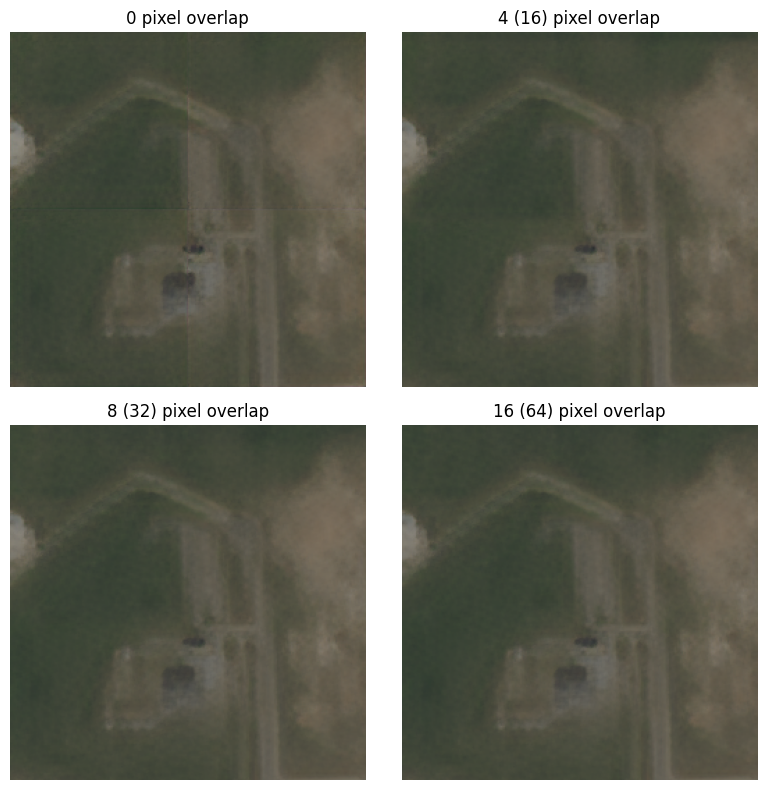

In [59]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def crop_and_show_grid(images_dict, extent):
    """
    Crop each numpy array image in the dict to the given extent and display in a 2x2 grid with labels.

    Args:
        images_dict (dict): Dict of 4 items {label: numpy array (H, W, C)}.
        extent (tuple): (left, upper, right, lower) crop box.
    """
    assert len(images_dict) == 4, "Exactly 4 images required"
    left, upper, right, lower = extent
    labels = list(images_dict.keys())
    cropped_imgs = [images_dict[label][upper:lower, left:right, ...] for label in labels]

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    for ax, img, label in zip(axes.flatten(), cropped_imgs, labels):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

x, y = 640, 384
crop_and_show_grid(images, (x, y, x+256, y+256))

# Part 2: New ROI (SF)

In [9]:
target_size = (1664, 1920)
ROOT_DIR = Path("./test_files_sf")
images = {
    "No seaming (single-image model)": np.array(Image.open(ROOT_DIR / "no_seaming_small.png").crop((0, 0, *target_size))),
    "No seaming (multi-temporal model)": np.array(Image.open(ROOT_DIR / "no_seaming_big.png").crop((0, 0, *target_size))),
    "Local padding (single-image model)": np.array(
        Image.open(ROOT_DIR / "local_padding_small.png").crop((0, 0, *target_size))),
    "Ground Truth": np.array(
        Image.open(ROOT_DIR / "ground_truth.tif").crop((0, 0, *target_size))),
    "Single-pass SR (single-image model)": np.array(
        Image.open(ROOT_DIR / "single_pass_small.png").crop((0, 0, *target_size))),
    "8 (32) px overlap (multi-temporal model, Hann filter)": np.array(
        Image.open(ROOT_DIR / "hann_overlap_8_40_big.png").crop((0, 0, *target_size))),
    "8 (32) px overlap (single-image model, Hann filter)": np.array(
        Image.open(ROOT_DIR / "hann_overlap_8_40_small.png").crop((0, 0, *target_size))),
    "16 (64) px overlap (multi-temporal model, Hann filter)": np.array(
        Image.open(ROOT_DIR / "hann_overlap_16_48_big.png").crop((0, 0, *target_size))),
    "16 (64) px overlap (single-image model, Hann filter)": np.array(
        Image.open(ROOT_DIR / "hann_overlap_16_48_small.png").crop((0, 0, *target_size))),
}

In [10]:
tile_size = 128
methods = ['mse', 'cross_entropy', 'cross_entropy_inner_vs_outer']
overlap_size = 32 #2

In [ ]:
global_ranges = {}
for method in methods:
    all_scores = []
    for name, image in images.items():
        _, h_scores, v_scores = evaluate_tile_transitions(image, tile_size, overlap_size, method, return_all_scores=True)
        all_scores.extend(h_scores.flatten())
        all_scores.extend(v_scores.flatten())
    global_ranges[method] = (np.min(all_scores), np.max(all_scores))

# Second pass: Visualize with consistent ranges
for method in methods:
    vmin, vmax = global_ranges[method]
    print(f"\nMethod: {method} | Global range: [{vmin:.2f}, {vmax:.2f}]")

    for img_name, image in images.items():
        _ = visualize_hotspots(img_name, image, tile_size, overlap_size,
                               method=method, vmin=vmin, vmax=vmax)

Plotting mse: 100%|██████████| 9/9 [00:00<00:00, 15.85it/s]


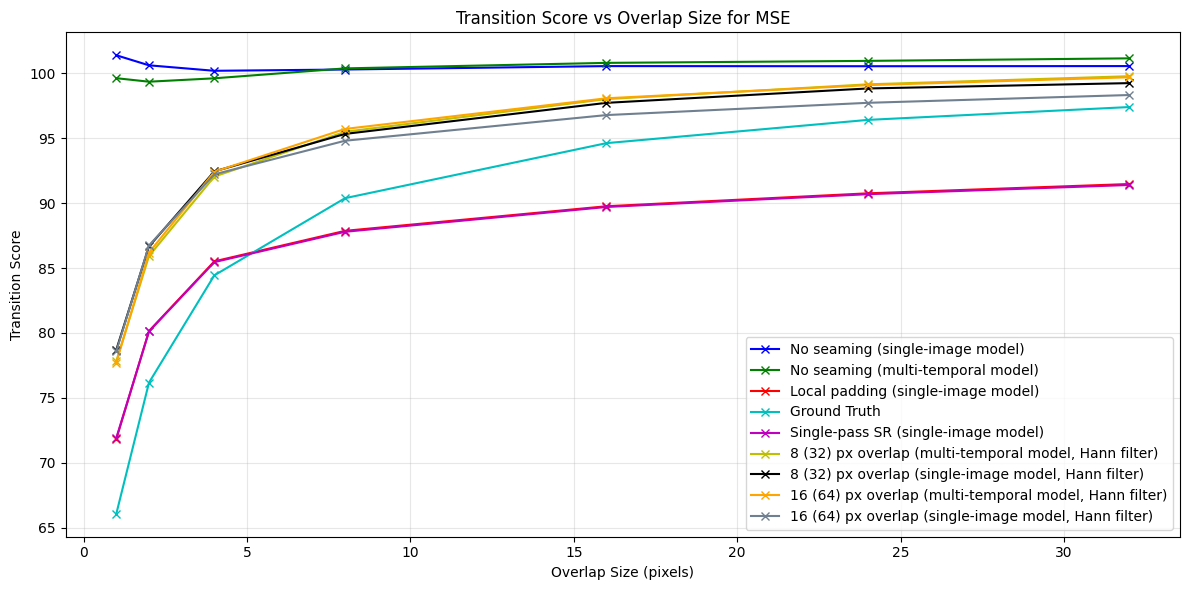

Plotting cross_entropy: 100%|██████████| 9/9 [03:17<00:00, 21.96s/it]


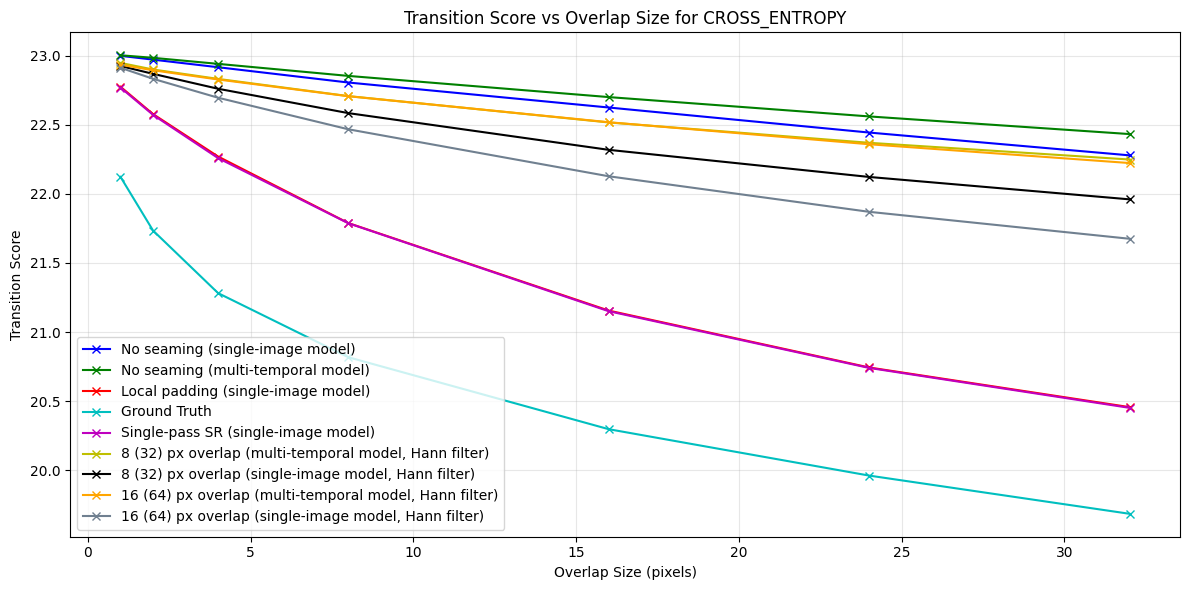

Plotting cross_entropy_inner_vs_outer: 100%|██████████| 9/9 [06:34<00:00, 43.82s/it]


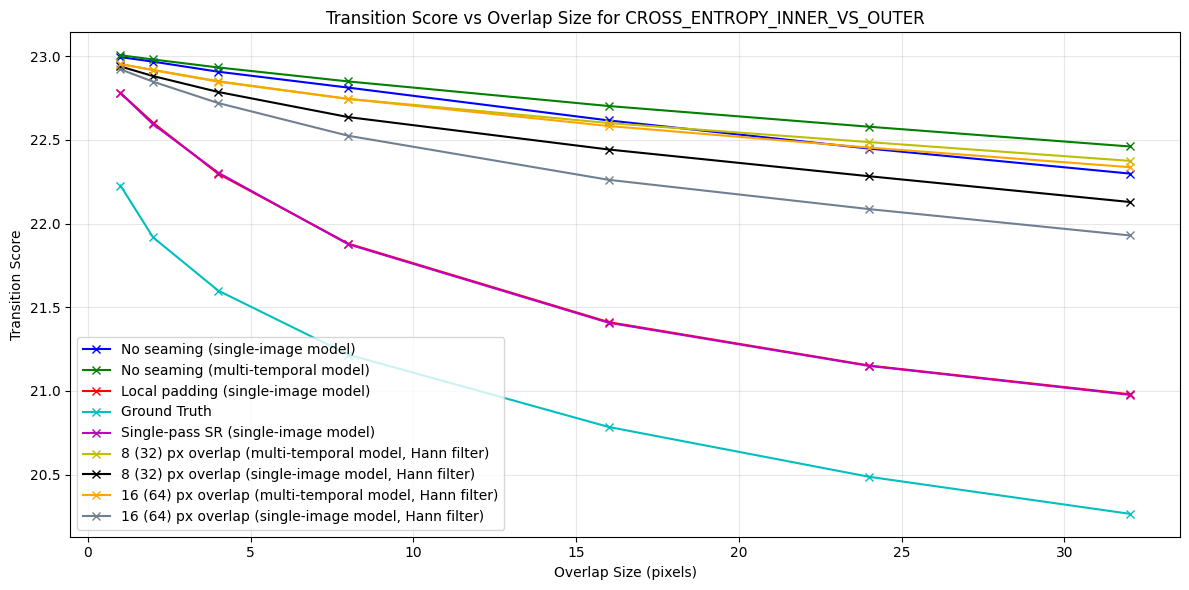

In [12]:
plot_overlap_dependency(images, tile_size, methods)

# Part 2.1: GT vs Reconstructed!!!

In [43]:
import numpy as np
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math

def get_joint_prob_distributions(pixels1, pixels2):
    """Convert two sets of pixels to aligned probability distributions"""
    pixels_flat1 = pixels1.reshape(-1, pixels1.shape[-1])
    pixels_flat2 = pixels2.reshape(-1, pixels2.shape[-1])
    all_pixels = [tuple(pixel) for pixel in np.vstack((pixels_flat1, pixels_flat2))]
    unique_colors = list(set(all_pixels))
    counter1 = Counter(tuple(pixel) for pixel in pixels_flat1)
    counter2 = Counter(tuple(pixel) for pixel in pixels_flat2)
    total1 = max(1, sum(counter1.values()))
    total2 = max(1, sum(counter2.values()))
    p = np.array([counter1.get(color, 0) / total1 for color in unique_colors])
    q = np.array([counter2.get(color, 0) / total2 for color in unique_colors])
    return p, q

def calculate_cross_entropy(p, q):
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1)
    q = np.clip(q, epsilon, 1)
    return -np.sum(p * np.log(q))

REQUIRES_INNER_VALUES = ['cross_entropy_inner_vs_outer', 'error_rate_ratio_mse']
REQUIRES_GT = ['mse_sr_sub_mse_gt','error_rate_ratio_mse']

def evaluate_tile_transitions(image, tile_size, overlap_size=1, method='cross_entropy',
                              return_all_scores=False, ground_truth=None):
    """
    Extended tile transition evaluation.
    For methods that require ground truth, ground_truth must be provided.

    For "mse_gt": score = mse(reconstructed outer) / mse(ground_truth outer)
    For "error_rate_ratio_psnr": score = (PSNR on GT vs reconstructed at outer) / (PSNR on GT vs reconstructed at inner)
    For "error_rate_ratio_ssim": score = (SSIM on GT vs reconstructed at outer) / (SSIM on GT vs reconstructed at inner)
    """
    if method in REQUIRES_GT and ground_truth is None:
        raise ValueError("Ground truth image must be provided for method {}".format(method))
    height, width, channels = image.shape
    scores = []
    n_tiles_h = height // tile_size
    n_tiles_w = width // tile_size
    horizontal_scores = np.zeros((n_tiles_h, n_tiles_w - 1)) if return_all_scores else None
    vertical_scores = np.zeros((n_tiles_h - 1, n_tiles_w)) if return_all_scores else None
    data_range = image.max() - image.min()

    # Horizontal transitions
    for i in range(n_tiles_h):
        for j in range(n_tiles_w - 1):
            # Outer boundaries (reconstructed)
            left_outer = image[i*tile_size:(i+1)*tile_size,
                               (j+1)*tile_size - overlap_size:(j+1)*tile_size][:, ::-1]
            right_outer = image[i*tile_size:(i+1)*tile_size,
                                (j+1)*tile_size:(j+1)*tile_size + overlap_size]

            if method in REQUIRES_GT:
                # Outer boundaries (ground truth)
                gt_left_outer = ground_truth[i*tile_size:(i+1)*tile_size,
                                             (j+1)*tile_size - overlap_size:(j+1)*tile_size][:, ::-1]
                gt_right_outer = ground_truth[i*tile_size:(i+1)*tile_size,
                                              (j+1)*tile_size:(j+1)*tile_size + overlap_size]
            if method in REQUIRES_INNER_VALUES:
                # Inner boundaries (reconstructed)
                left_inner = image[i*tile_size:(i+1)*tile_size,
                                   (j+1)*tile_size - 2*overlap_size:(j+1)*tile_size - overlap_size][:, ::-1]
                right_inner = image[i*tile_size:(i+1)*tile_size,
                                    (j+1)*tile_size + overlap_size:(j+1)*tile_size + 2*overlap_size]

                if method in REQUIRES_GT:
                    # Inner boundaries (ground truth)
                    gt_left_inner = ground_truth[i*tile_size:(i+1)*tile_size,
                                                 (j+1)*tile_size - 2*overlap_size:(j+1)*tile_size - overlap_size][:, ::-1]
                    gt_right_inner = ground_truth[i*tile_size:(i+1)*tile_size,
                                                  (j+1)*tile_size + overlap_size:(j+1)*tile_size + 2*overlap_size]
                if method == 'cross_entropy_inner_vs_outer':
                    p, q = get_joint_prob_distributions(left_inner, right_outer)
                    left_inner_vs_right_outer = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
                    p, q = get_joint_prob_distributions(right_inner, left_outer)
                    right_inner_vs_left_outer = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
                    score = (left_inner_vs_right_outer + right_inner_vs_left_outer) / 2
                elif method == 'error_rate_ratio_mse':
                    mse_right_outer = np.mean((right_outer - gt_right_outer) ** 2)
                    mse_left_outer = np.mean((left_outer - gt_left_outer) ** 2)
                    outer_mse = (mse_right_outer + mse_left_outer) / 2

                    mse_right_inner = np.mean((right_inner - gt_right_inner) ** 2)
                    mse_left_inner = np.mean((left_inner - gt_left_inner) ** 2)
                    inner_mse = (mse_right_inner + mse_left_inner) / 2
                    score = outer_mse / inner_mse

            elif method == 'cross_entropy':
                p, q = get_joint_prob_distributions(left_outer, right_outer)
                score = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
            elif method == 'mse':
                score = np.mean((left_outer - right_outer) ** 2)
            elif method == 'mse_sr_sub_mse_gt':
                mse_rec = np.mean((left_outer - right_outer) ** 2)
                mse_gt = np.mean((gt_left_outer - gt_right_outer) ** 2)
                score = mse_rec - mse_gt
            else:
                raise ValueError("Unknown method: {}".format(method))
            scores.append(score)
            if return_all_scores:
                horizontal_scores[i,j] = score

    # Vertical transitions
    for i in range(n_tiles_h - 1):
        for j in range(n_tiles_w):
            # Outer boundaries (reconstructed)
            upper_outer = image[(i+1)*tile_size - overlap_size:(i+1)*tile_size,
                                j*tile_size:(j+1)*tile_size][::-1, :]
            lower_outer = image[(i+1)*tile_size:(i+1)*tile_size + overlap_size,
                                j*tile_size:(j+1)*tile_size]

            if method in REQUIRES_GT:
                # Outer boundaries (ground truth)
                gt_upper_outer = ground_truth[(i+1)*tile_size - overlap_size:(i+1)*tile_size,
                                              j*tile_size:(j+1)*tile_size][::-1, :]
                gt_lower_outer = ground_truth[(i+1)*tile_size:(i+1)*tile_size + overlap_size,
                                              j*tile_size:(j+1)*tile_size]

            if method in REQUIRES_INNER_VALUES:
                # Inner boundaries (reconstructed)
                upper_inner = image[(i+1)*tile_size - 2*overlap_size:(i+1)*tile_size - overlap_size,
                                    j*tile_size:(j+1)*tile_size][::-1, :]
                lower_inner = image[(i+1)*tile_size + overlap_size:(i+1)*tile_size + 2*overlap_size,
                                    j*tile_size:(j+1)*tile_size]

                if method in REQUIRES_GT:
                    # Inner boundaries (ground truth)
                    gt_upper_inner = ground_truth[(i+1)*tile_size - 2*overlap_size:(i+1)*tile_size - overlap_size,
                                                  j*tile_size:(j+1)*tile_size][::-1, :]
                    gt_lower_inner = ground_truth[(i+1)*tile_size + overlap_size:(i+1)*tile_size + 2*overlap_size,
                                                  j*tile_size:(j+1)*tile_size]

                if method == 'cross_entropy_inner_vs_outer':
                    p, q = get_joint_prob_distributions(upper_inner, lower_outer)
                    upper_inner_vs_lower_outer = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
                    p, q = get_joint_prob_distributions(lower_inner, upper_outer)
                    lower_inner_vs_upper_outer = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
                    score = (upper_inner_vs_lower_outer + lower_inner_vs_upper_outer) / 2
                elif method == 'error_rate_ratio_mse':
                    mse_upper_outer = np.mean((upper_outer - gt_upper_outer) ** 2)
                    mse_lower_outer = np.mean((lower_outer - gt_lower_outer) ** 2)
                    outer_mse = (mse_upper_outer + mse_lower_outer) / 2

                    mse_upper_inner = np.mean((upper_inner - gt_upper_inner) ** 2)
                    mse_lower_inner = np.mean((lower_inner - gt_lower_inner) ** 2)
                    inner_mse = (mse_upper_inner + mse_lower_inner) / 2
                    score = outer_mse / inner_mse
            elif method == 'cross_entropy':
                p, q = get_joint_prob_distributions(upper_outer, lower_outer)
                score = (calculate_cross_entropy(p, q) + calculate_cross_entropy(q, p)) / 2
            elif method == 'mse':
                score = np.mean((upper_outer - lower_outer) ** 2)
            elif method == 'mse_sr_sub_mse_gt':
                mse_rec = np.mean((upper_outer - lower_outer) ** 2)
                mse_gt = np.mean((gt_upper_outer - gt_lower_outer) ** 2)
                score = mse_rec - mse_gt
            else:
                raise ValueError("Unknown method: {}".format(method))
            scores.append(score)
            if return_all_scores:
                vertical_scores[i, j] = score

    if return_all_scores:
        return np.mean(scores) if scores else 0, horizontal_scores, vertical_scores
    return np.mean(scores) if scores else 0

def visualize_hotspots(image_name, image, tile_size, overlap_size, method='cross_entropy',
                       vmin=None, vmax=None, ground_truth=None):
    """
    Extended visualization. For methods that require ground truth, pass it via the ground_truth parameter.
    """
    height, width = image.shape[:2]
    n_tiles_h = height // tile_size
    n_tiles_w = width // tile_size
    if method in REQUIRES_GT:
        _, h_scores, v_scores = evaluate_tile_transitions(
            image, tile_size, overlap_size, method, return_all_scores=True, ground_truth=ground_truth)
    else:
        _, h_scores, v_scores = evaluate_tile_transitions(
            image, tile_size, overlap_size, method, return_all_scores=True)
    overlay = np.zeros((height, width, 4))
    cmap = LinearSegmentedColormap.from_list('hotspot', ['green','yellow','red'] if method != 'mse_sr_sub_mse_gt' else ['blue', 'cyan', 'green', 'yellow', 'red'])
    current_vmin = vmin if vmin is not None else min(h_scores.min(), v_scores.min())
    current_vmax = vmax if vmax is not None else max(h_scores.max(), v_scores.max())
    overlap_for_viz = 4
    for i in range(n_tiles_h):
        for j in range(n_tiles_w - 1):
            x = (j+1)*tile_size
            score = h_scores[i,j]
            norm_score = (score - current_vmin) / (current_vmax - current_vmin)
            color = cmap(norm_score)
            overlay[i*tile_size:(i+1)*tile_size,
                    x - overlap_for_viz : x + overlap_for_viz, :] = color
    for i in range(n_tiles_h - 1):
        for j in range(n_tiles_w):
            y = (i+1)*tile_size
            score = v_scores[i,j]
            norm_score = (score - current_vmin) / (current_vmax - current_vmin)
            color = cmap(norm_score)
            overlay[y - overlap_for_viz : y + overlap_for_viz,
                    j*tile_size:(j+1)*tile_size, :] = color
    overlay[...,3] = np.where(overlay[...,:3].max(axis=-1) > 0, 1, 0.3).astype(float)
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_axes([0.02, 0.1, 0.45, 0.8])
    ax1.imshow(image)
    ax1.set_title(image_name, pad=10)
    ax1.axis('off')
    ax2 = fig.add_axes([0.47, 0.1, 0.45, 0.8])
    ax2.imshow(image)
    boundary_plot = ax2.imshow(overlay, vmin=current_vmin, vmax=current_vmax, cmap=cmap)
    all_scores = np.concatenate((v_scores, h_scores), axis=None)
    mean_score = all_scores.mean()
    max_score = all_scores.max()
    min_score = all_scores.min()
    ax2.set_title("Transition Hotspots {}@{} (mean={:.2f}, max={:.2f}, min={:.2f})".format(
        method.upper(), overlap_size, mean_score, max_score, min_score), pad=10)
    ax2.axis('off')
    cax = fig.add_axes([0.94, 0.1, 0.02, 0.8])
    fig.colorbar(boundary_plot, cax=cax, label="Transition Score")
    plt.show()
    return current_vmin, current_vmax

In [44]:
target_size = (1664, 1920)
ROOT_DIR = Path("./test_files_sf")
images = {
    "No seaming (single-image model)": np.array(Image.open(ROOT_DIR / "no_seaming_small.png").crop((0, 0, *target_size))),
    "No seaming (multi-temporal model)": np.array(Image.open(ROOT_DIR / "no_seaming_big.png").crop((0, 0, *target_size))),
    "Local padding (single-image model)": np.array(
        Image.open(ROOT_DIR / "local_padding_small.png").crop((0, 0, *target_size))),
    "Single-pass SR (single-image model)": np.array(
        Image.open(ROOT_DIR / "single_pass_small.png").crop((0, 0, *target_size))),
    "8 (32) px overlap (multi-temporal model, Hann filter)": np.array(
        Image.open(ROOT_DIR / "hann_overlap_8_40_big.png").crop((0, 0, *target_size))),
    "8 (32) px overlap (single-image model, Hann filter)": np.array(
        Image.open(ROOT_DIR / "hann_overlap_8_40_small.png").crop((0, 0, *target_size))),
    "16 (64) px overlap (multi-temporal model, Hann filter)": np.array(
        Image.open(ROOT_DIR / "hann_overlap_16_48_big.png").crop((0, 0, *target_size))),
    "16 (64) px overlap (single-image model, Hann filter)": np.array(
        Image.open(ROOT_DIR / "hann_overlap_16_48_small.png").crop((0, 0, *target_size))),
}

ground_truth_image = np.array(Image.open(ROOT_DIR / "ground_truth.tif").crop((0, 0, *target_size)))

In [45]:
tile_size = 128
methods = ['mse_sr_sub_mse_gt']
overlap_size = 8

In [ ]:
global_ranges = {}
for method in methods:
    all_scores = []
    for name, image in images.items():
        _, h_scores, v_scores = evaluate_tile_transitions(image, tile_size, overlap_size, method, return_all_scores=True, ground_truth=ground_truth_image)
        all_scores.extend(h_scores.flatten())
        all_scores.extend(v_scores.flatten())
    if method != 'error_rate_ratio_mse':
        global_ranges[method] = (np.min(all_scores), np.max(all_scores))
    else:
        min_val = np.min(all_scores)
        max_val = np.max(all_scores)
        max_amplitude = max(1 - min_val, max_val - 1)
        global_ranges[method] = (1 - max_amplitude, 1 + max_amplitude)

# Second pass: Visualize with consistent ranges
for method in methods:
    vmin, vmax = global_ranges[method]
    print(f"\nMethod: {method} | Global range: [{vmin:.2f}, {vmax:.2f}]")

    for img_name, image in images.items():
        _ = visualize_hotspots(img_name, image, tile_size, overlap_size,
                               method=method, vmin=vmin, vmax=vmax, ground_truth=ground_truth_image)